In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle
sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# no text wrapping
display(HTML("<style>.dataframe td { white-space: nowrap; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_colwidth', 200)

In [2]:
# base dataframes
df_hist = pd.read_pickle('calculations\df_hist.pickle')
df_spec = pd.read_pickle('calculations\df_spec.pickle')

# need to recreate summary with updated calculations
# define df_summary
df_summary = pd.merge(
    df_hist[['sample_id', 'id']].groupby('sample_id').count().rename({'id':'n_hist'}, axis=1),
    df_spec[['sample_id', 'id']].groupby('sample_id').count().rename({'id':'n_spec'}, axis=1),
    on='sample_id',
    how='left'
).fillna(0)
df_summary.n_spec = df_summary.n_spec.astype(int)

# improved bins, plotting and error checking

In [3]:
# bins used by specimen table
# looks like bio data doesn't need to end with a 3 or 8
(df_spec.fork_length % 10).value_counts()

3    38505
8    34192
0      242
9      231
4      228
2      225
5      224
1      207
7      206
6      187
Name: fork_length, dtype: Int64

In [4]:
df_spec.notna().sum()
# note: there are only 6 sex data and they are the import error (should be bio) from the other notebook

id                      74666
fork_length             74447
weight                    429
river_age               74664
notes                   74666
sample_id               74666
sex_id                      6
status_id               74666
age_type                74664
sweep_id                74666
life_stage_id           74666
old_id                  74666
smart_river_age         74664
smart_river_age_type    74664
matching_id             74666
dtype: int64

In [5]:
# check: confirm that values ending in not 3/8 have more weight/sex

# still no sex data, but most of the weight data is here 
# (you would expect exactly 80% if it was 100% because more detailed measurements could include n%5==3)

df_spec[df_spec.fork_length % 5 != 3][['weight', 'sex_id']].notna().sum() / df_spec[['weight', 'sex_id']].notna().sum()

weight   0.841
sex_id   0.000
dtype: float64

In [6]:
# bins go from 23 to 163
df_spec.fork_length.describe()

count   74447.000
mean       57.040
std        23.221
min        23.000
25%        43.000
50%        48.000
75%        68.000
max       163.000
Name: fork_length, dtype: float64

# improved matching algorithm

In [7]:
def match_spec_and_bio(df_specimen, df_bio, n_sample, debug=False, right=True):
    
    """ right=True means bins are right inclusive, this is the lowest error option by a significant margin (see below) """

    # create bins for fork lengths, create lists representing counts per bin
    bins = [x for x in range(20, 170, 5)]
    bin_s = df_specimen[df_specimen.sample_id==n_sample].groupby(['sample_id', pd.cut(df_specimen.fork_length, bins, right=right)]).fork_length.count().to_list()
    bin_b = df_bio[df_bio.sample_id==n_sample].groupby(['sample_id', pd.cut(df_bio.fork_length, bins, right=right)]).fork_length.count().to_list()
    
    if debug:
        print('bins')
        print(bin_s)
        print(bin_b)
        print()
    
    # difference between two lists of fish counts
    list_diff = []
    for i, bin in enumerate(bin_b):
        bin_s[i] = bin_s[i] - bin
        list_diff += [bin_s[i]]
        
    # evaluate how far negative counts (unmatched fish) are from matchable entries
    n = 0
    i_max = len(list_diff)
    for i, bin in enumerate(list_diff):
        if debug:
            print(i, 'list_diff')
            print(list_diff)
        if bin < 0:
            for j in range(1, i_max):  
                if i-j >= 0:
                    if (subtract := list_diff[i-j]) > 0:
                        subtract = subtract if subtract <= -bin else -bin
                        list_diff[i-j] -= subtract
                        bin += subtract
                        n += j * subtract
                        if bin == 0:
                            break  # break the j loop   
                if i+j < i_max:
                    if (subtract := list_diff[i+j]) > 0:
                        subtract = subtract if subtract <= -bin else -bin
                        list_diff[i+j] -= subtract
                        bin += subtract
                        n += j * subtract
                        if bin == 0:
                            break
            list_diff[i] = bin

            if bin < 0:  # unmatchable penalty
                return 9999

    if debug:
        print()
        print(n)
        print(list_diff)

    return n * 5  # 5 is the bin width, ie, the error per fish per bin distance


In [8]:
# combine calculated matching errors into df_summary

sample_ids = [x for x in df_hist.sample_id.unique() if x in df_spec.sample_id.unique()]

error = []
for sample_id in sample_ids:
    error += [[sample_id, match_spec_and_bio(df_spec, df_hist, sample_id, right=True)]]
    
df_summary = pd.merge(
    df_summary.reset_index(),
    pd.DataFrame(error, columns=['sample_id', 'error']),
    on='sample_id',
    how='left'
).set_index('sample_id')

df_summary.loc[df_summary.error.isna(), 'error'] = 9999

In [9]:
df_summary.describe(percentiles=[.01, .1, .9, .99])

,n_hist,n_spec,error
count,793.000,793.000,793.000
mean,34.709,94.156,382.813
std,39.659,109.540,1876.454
min,1.000,0.000,0.000
1%,1.000,0.000,0.000
10%,5.000,8.000,0.000
50%,25.000,61.000,0.000
90%,78.000,209.800,49.000
99%,184.400,491.720,9999.000
max,346.000,1016.000,9999.000


# left vs right inclusive bins (right wins)

In [10]:
%%time
left_vs_right = []
for i in sample_ids:
    left_vs_right += [[i, match_spec_and_bio(df_spec, df_hist, i, right=False), match_spec_and_bio(df_spec, df_hist, i, right=True)]]

Wall time: 21.2 s


,sample_id,left_error,right_error
count,775.000,775.000,775.000
mean,6398.706,191.289,159.470
std,1346.040,1182.737,1184.284
min,4404.000,0.000,0.000
1%,4433.480,0.000,0.000
10%,4548.400,0.000,0.000
50%,7168.000,10.000,0.000
90%,7811.600,150.000,35.000
99%,7981.260,9999.000,9999.000
max,8001.000,9999.000,9999.000


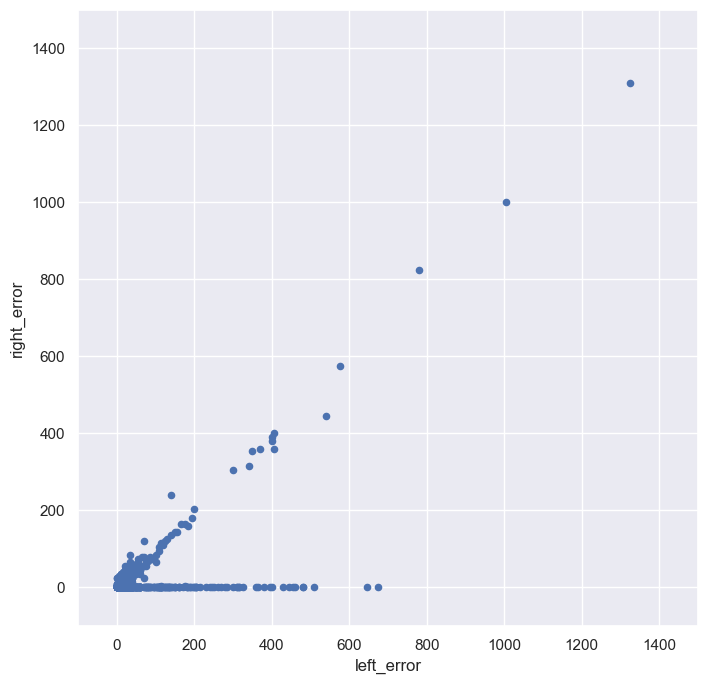

In [11]:
# confirm that right inclusive bins are the correct choice for this dataset
df_left_vs_right = pd.DataFrame(left_vs_right, columns=['sample_id', 'left_error', 'right_error'])
display(df_left_vs_right.describe(percentiles=[.01, .1, .9, .99]))
df_left_vs_right.plot(kind='scatter', x='left_error', y='right_error', figsize=(8,8), xlim=(-100,1500), ylim=(-100,1500));


right==True ERROR: 0


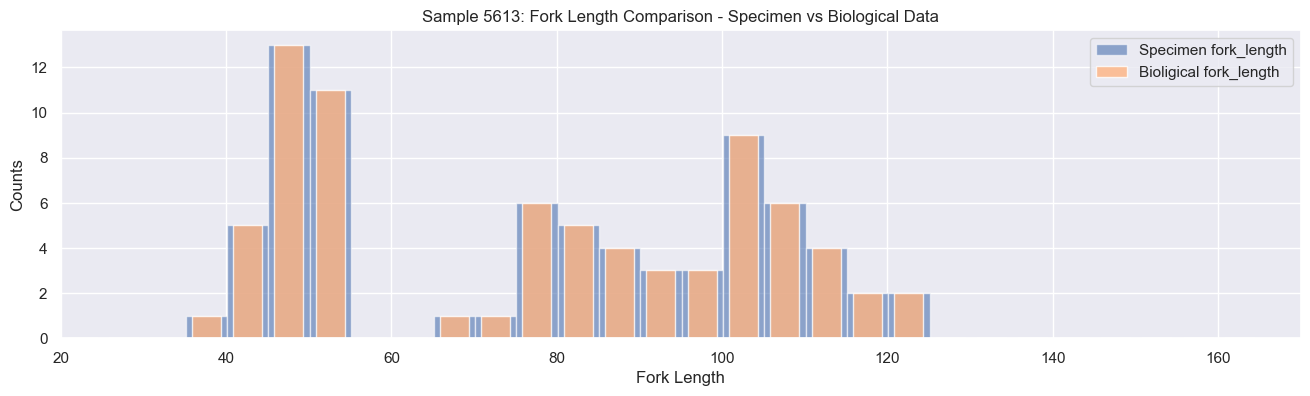


right==False ERROR: 115


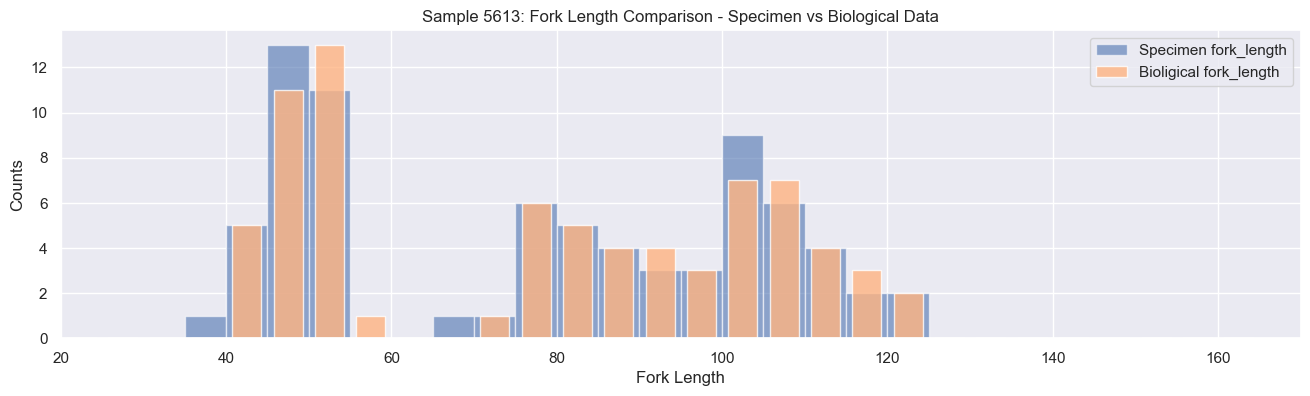

In [12]:
# plotting function for an example

def plot_fork_length_by_sample(df_specimen, df_historical, sample_id, feature='fork_length', bin_width=5, density=False, subtitle='', duplicate='unknown', right=False):
    """ duplicate can be True, False, or 'unknown' """
    
    figsize=(16,4)
    offset = 0.1 if right else 0  # this is a hack - plt.hist() doesn't seem to have a right inclusive option for bins...
    bins_plot = [x*5+offset + 20 for x in range(30)]  # centered on n%5==3 like df_spec, rounded to int%5 (could use +20.5 also to center perfectly on n%5==3)
    
    if duplicate == 'unknown':
        colours = sns.color_palette()[0], sns.color_palette('pastel')[1]
    elif duplicate: # duplicated
        colours = sns.color_palette()[0], sns.color_palette('pastel')[2]
    else: # not duplicated
        colours = sns.color_palette()[0], sns.color_palette('deep')[6]
        
    plt.figure(figsize=figsize)
    plt.xlim(20, 170)  # use same scale for all histograms for easy comparison
    df_specimen.loc[df_specimen.sample_id==sample_id, feature].dropna().hist(alpha=0.6, color=colours[0], density=density, label=f'Specimen {feature}', bins=bins_plot)
    df_historical.loc[df_historical.sample_id==sample_id, feature].dropna().hist(alpha=0.8, color=colours[1], density=density, label=f'Bioligical {feature}', bins=bins_plot, rwidth=0.7)
    
    feature_title = feature.title().replace("_"," ")
    plt.legend(loc='upper right')
    subtitle = ' - ' + subtitle if subtitle else ''
    plt.title(f'Sample {sample_id}: {feature_title} Comparison - Specimen vs Biological Data{subtitle}')
    plt.ylabel('Counts')
    plt.xlabel(f'{feature_title}')
    plt.show()


n_sample = 5613
print('\nright==True ERROR:', match_spec_and_bio(df_spec, df_hist, n_sample, right=True))
plot_fork_length_by_sample(df_spec, df_hist, n_sample, right=True)
print('\nright==False ERROR:', match_spec_and_bio(df_spec, df_hist, n_sample, right=False))
plot_fork_length_by_sample(df_spec, df_hist, n_sample, right=False)

# Save Summary File

In [13]:
df_summary.to_pickle('calculations\df_summary.pickle')